# 5. Feature Extraction

In this step we will extract features from our created graphs.

## 5.1 load in graphs

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

In [2]:
# Get connectivity adjacency matrix
Conn_Adj = pd.read_csv('files/Conn_Adj.csv')
Conn_Adj = Conn_Adj.set_index('Unnamed: 0')

In [57]:
# Get intensity adjacency matrix
Intensity_Adj = pd.read_csv('files/Intensity_Adj.csv')
Intensity_Adj = Intensity_Adj.set_index('Unnamed: 0')

In [3]:
# Create graph from adjacency matrix
G_Conn = nx.from_pandas_adjacency(Conn_Adj)

In [59]:
# Create graph from adjacency matrix
G_int = nx.from_pandas_adjacency(Intensity_Adj)

In [60]:
len(list(G_int.nodes))

6533

In [61]:
len(list(G_Conn.nodes))

6533

## 5.2 Extract features


#### 5.2.1 Node features
We will start with extracting some basic centrality features, degree, betweenness and closeness. Followed by constructing power laws. Here we will focus on combining attributes of an egonet, the 1-step neighbourhood of a node to detect anomalies, we will look at number of connected nodes, number of edges, total weight and the principal eigenvalue of a node's egonet. In a next step we will leverage the Mahalanobis distance on the SimRank similarity matrix to detect outliers.

**Centrality features**

In [62]:
# Extract degree centrality
df_degree = pd.DataFrame.from_dict(nx.degree_centrality(G_int), orient='index').rename(columns={0:'Degree_centrality'})

In [63]:
df_degree.head()

,Degree_centrality
pete.davis@enron.com,0.001378
vince.kaminski@enron.com,0.050367
To_aol.com,0.005052
kay.mann@enron.com,0.039651
suzanne.adams@enron.com,0.003674


In [87]:
# Extract betweenness centrality
df_betweenness = pd.DataFrame.from_dict(nx.betweenness_centrality(G_int), orient='index').rename(columns={0:'Betweenness_centrality'})

In [88]:
df_betweenness.head()

,Betweenness_centrality
pete.davis@enron.com,0.000003
vince.kaminski@enron.com,0.025625
To_aol.com,0.000674
kay.mann@enron.com,0.013190
suzanne.adams@enron.com,0.000026


In [89]:
# Extract closeness centrality
df_closeness = pd.DataFrame.from_dict(nx.closeness_centrality(G_int), orient='index').rename(columns={0:'Closeness_centrality'})

In [90]:
df_closeness.head()

,Closeness_centrality
pete.davis@enron.com,0.313541
vince.kaminski@enron.com,0.421937
To_aol.com,0.387472
kay.mann@enron.com,0.388370
suzanne.adams@enron.com,0.343193


In [91]:
# Concatenate dataframes
df_features = pd.concat([df_degree, df_betweenness, df_closeness], axis=1)

In [92]:
df_features.head()

,Degree_centrality,Betweenness_centrality,Closeness_centrality
pete.davis@enron.com,0.001378,0.000003,0.313541
vince.kaminski@enron.com,0.050367,0.025625,0.421937
To_aol.com,0.005052,0.000674,0.387472
kay.mann@enron.com,0.039651,0.013190,0.388370
suzanne.adams@enron.com,0.003674,0.000026,0.343193


In [93]:
df_features.describe()

,Degree_centrality,Betweenness_centrality,Closeness_centrality
count,6533.000000,6.533000e+03,6533.000000
mean,0.002522,3.405802e-04,0.314374
std,0.006535,2.753625e-03,0.035859
min,0.000153,0.000000e+00,0.157038
25%,0.000459,2.084655e-07,0.292679
50%,0.000765,7.790127e-06,0.315084
75%,0.001990,6.006203e-05,0.337223
max,0.146816,1.083224e-01,0.467005


In [94]:
# Check for NaN values
df_features.isnull().sum(axis=0)

Degree_centrality         0
Betweenness_centrality    0
Closeness_centrality      0
dtype: int64

**Construct power laws**

As mentioned earlier we will extract different attributes of the egonet of a node to construct power laws. These power laws are a combination of the attributes which indicate an anomaly.

* Number of nodes in an egonet
* Number of edges in an egonet
* Total weight of the egonet
* Spectral radius of the egonet, the principal eigenvalue of the egonet

We start by defining some defintions to extract the afore mentioned features

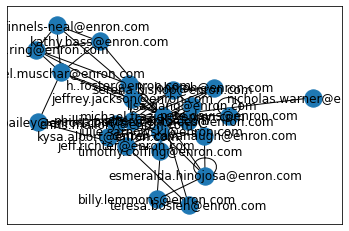

In [95]:
# Draw an example of an egonet
nx.draw_networkx(nx.ego_graph(G_int, 'michael.frazier@enron.com'))

In [96]:
# Definition for Number of edges
def nr_edges(Name):
    nr_edges = nx.ego_graph(G_int, Name).number_of_edges()
    return(nr_edges)

In [97]:
nr_edges('michael.frazier@enron.com')

61

In [98]:
# Definition for the Number of nodes
def nr_nodes(Name):
    nr_nodes = nx.ego_graph(G_int, Name).number_of_nodes()
    return nr_nodes

In [99]:
nr_nodes('michael.frazier@enron.com')

24

In [100]:
# Definition to get sum of weights
def total_weights(Name):
    total_weights = nx.ego_graph(G_int, Name).size(weight="weight")
    return total_weights

In [101]:
total_weights('michael.frazier@enron.com')

3340.0

In [102]:
from numpy import linalg as LA

In [103]:
# Definition to extract principal eigenvalue
def princip_eigval(Name):
    # Convert graph to array
    array = nx.to_numpy_array(nx.ego_graph(G_int, Name))
    princip_eigval = LA.eigvals(array).max()
    return princip_eigval

In [104]:
princip_eigval('michael.frazier@enron.com')

2413.426802893317

In [ ]:
# Loop over all nodes and extract features
list_nr_nodes = []
list_nr_edges = []
list_total_weights = []
list_eigvals = []
for name in Intensity_Adj.index.tolist():
    list_nr_nodes.append(nr_nodes(name))
    list_nr_edges.append(nr_edges(name))
    list_total_weights.append(total_weights(name))
    list_eigvals.append(princip_eigval(name))

In [107]:
# Add features to dataframe
df_ego_features = pd.DataFrame(index=Intensity_Adj.index.tolist(), data={'Nr_Nodes':list_nr_nodes, 'Nr_Edges':list_nr_edges,
                                                                   'Total_Weight':list_total_weights, 'Eigenvalue':list_eigvals})

In [108]:
df_ego_features.head()

,Nr_Nodes,Nr_Edges,Total_Weight,Eigenvalue
pete.davis@enron.com,8,27,2989.0,2414.157195+0.000000j
vince.kaminski@enron.com,328,1745,18600.0,2383.983616+0.000000j
To_aol.com,34,146,4648.0,2249.756379+0.000000j
kay.mann@enron.com,258,1757,26265.0,1464.451618+0.000000j
suzanne.adams@enron.com,25,208,2567.0,338.469365+0.000000j


In [109]:
df_ego_features.describe()

,Nr_Nodes,Nr_Edges,Total_Weight,Eigenvalue
count,6533.000000,6533.000000,6533.000000,6533.000000+0.000000j
mean,17.382673,105.517833,1583.314710,176.948333+0.000000j
std,42.489488,387.941833,6687.785492,357.377523+0.000000j
min,2.000000,1.000000,2.000000,2.0000000+0.0000000j
25%,4.000000,4.000000,46.000000,23.1300200+0.0000000j
50%,6.000000,12.000000,125.000000,56.4754540+0.0000000j
75%,14.000000,48.000000,672.000000,176.075708+0.000000j
max,958.000000,8775.000000,163872.000000,5315.700554+0.000000j


To detect possible outliers we can combine some of these features. 

* **Number of nodes vs number of edges**: Extremely dense neighborhoods of a node correspond to near-cliques, whereas extremely sparse neighborhoods of a node are stars.

* **Total weight vs number of edges**: If edges are used unusually frequently in the neighborhood of a node, this will result in a high value of the weight feature relative to the edge feature.

* **Principal eigenvalue vs total weight** This approach detects a single dominating heavy edge in the neighborhood of a node.

In [110]:
df_ego_features['ego_Density'] = np.log(df_ego_features.Nr_Edges)/np.log(df_ego_features.Nr_Nodes)

In [111]:
df_ego_features['Heavy_vicinity'] = np.log(df_ego_features.Total_Weight)/np.log(df_ego_features.Nr_Edges)

In [112]:
df_ego_features['Dominant_edge'] = np.log(df_ego_features.Eigenvalue)/np.log(df_ego_features.Total_Weight)

Because some nodes have only one edge the second power law won't hold up for nodes with only 1 edge. To circumvent this problem we will replace the inifinite value by the edge weight. As the intensity of an egonet with only 1 edge can be represented by the weight of that edge. 

In [113]:
df_ego_features.Heavy_vicinity[df_ego_features.Nr_Edges==1] = df_ego_features.Total_Weight[df_ego_features.Nr_Edges==1]

C:\Users\andre\AppData\Local\Temp/ipykernel_21484/1941707962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ego_features.Heavy_vicinity[df_ego_features.Nr_Edges==1] = df_ego_features.Total_Weight[df_ego_features.Nr_Edges==1]


In [114]:
df_ego_features.head()

,Nr_Nodes,Nr_Edges,Total_Weight,Eigenvalue,ego_Density,Heavy_vicinity,Dominant_edge
pete.davis@enron.com,8,27,2989.0,2414.157195+0.000000j,1.584963,2.428122,0.973310+0.000000j
vince.kaminski@enron.com,328,1745,18600.0,2383.983616+0.000000j,1.288537,1.317021,0.791028+0.000000j
To_aol.com,34,146,4648.0,2249.756379+0.000000j,1.413244,1.694394,0.914069+0.000000j
kay.mann@enron.com,258,1757,26265.0,1464.451618+0.000000j,1.345474,1.361999,0.716317+0.000000j
suzanne.adams@enron.com,25,208,2567.0,338.469365+0.000000j,1.658199,1.470808,0.741919+0.000000j


In [115]:
df_ego_features.describe()

,Nr_Nodes,Nr_Edges,Total_Weight,Eigenvalue,ego_Density,Heavy_vicinity,Dominant_edge
count,6533.000000,6533.000000,6533.000000,6533.000000+0.000000j,6533.000000,6533.000000,6533.0000+0.0000j
mean,17.382673,105.517833,1583.314710,176.948333+0.000000j,1.264640,2.849906,0.820255+0.000000j
std,42.489488,387.941833,6687.785492,357.377523+0.000000j,0.339271,6.346724,0.092477+0.000000j
min,2.000000,1.000000,2.000000,2.0000000+0.0000000j,0.000000,1.175586,0.551296+0.000000j
25%,4.000000,4.000000,46.000000,23.1300200+0.0000000j,1.160558,1.566358,0.746860+0.000000j
50%,6.000000,12.000000,125.000000,56.4754540+0.0000000j,1.340978,1.854134,0.811117+0.000000j
75%,14.000000,48.000000,672.000000,176.075708+0.000000j,1.486477,2.453445,0.891847+0.000000j
max,958.000000,8775.000000,163872.000000,5315.700554+0.000000j,1.765557,243.000000,1.000000+0.000000j


In [116]:
# Check if there are some empty values
df_ego_features.isnull().value_counts()

Nr_Nodes  Nr_Edges  Total_Weight  Eigenvalue  ego_Density  Heavy_vicinity  Dominant_edge
False     False     False         False       False        False           False            6533
dtype: int64

In [117]:
# Store variables
df_features = pd.concat([df_features, df_ego_features], axis=1)

**Levaraging the mahalonobis distance**

Here we will use the mahalonobis distance on the SimRank similarity matrix of the network. We will represent all nodes on how similar they are compared to each other. The nodes which deviate the most can be classified as anomolous. To get our similarity matrix we use the SimRank algorithm.

In [352]:
# Get similarity scores
sim = nx.simrank_similarity(G_Conn)

In [353]:
# Set to array
Similarity_matrix = np.array([[sim[u][v] for v in G_Conn] for u in G_Conn])

In [354]:
# Import package to calculate distance
from scipy.spatial import distance

In [355]:
# Compute mahalanobis distances
Mahalanobis_distances = []
for i in range(Similarity_matrix.shape[0]):
    mahala_distance = distance.mahalanobis(Similarity_matrix[i], Similarity_matrix.mean(axis=0), np.identity(6533))
    Mahalanobis_distances.append(mahala_distance)

In [356]:
# Store variable
df_features['Mahalanobis'] = Mahalanobis_distances

In [42]:
# Check output
df_features.head()

,Degree_centrality,Betweenness_centrality,Closeness_centrality,Nr_Nodes,Nr_Edges,Total_Weight,Eigenvalue,ego_Density,Heavy_vicinity,Dominant_edge,Mahalanobis
pete.davis@enron.com,0.001378,0.000003,0.313541,8,27,101.606970,27.865440+0.000000j,1.584963,1.402106,0.720040+0.000000j,1.667630
vince.kaminski@enron.com,0.050367,0.025625,0.421937,328,1745,2047.005277,47.325701+0.000000j,1.288537,1.021384,0.505901+0.000000j,1.288933
To_aol.com,0.005052,0.000674,0.387472,34,146,102.196724,17.703856+0.000000j,1.413244,0.928424,0.621103+0.000000j,1.281622
kay.mann@enron.com,0.039651,0.013190,0.388370,258,1757,1500.869686,59.618147+0.000000j,1.345474,0.978911,0.558938+0.000000j,1.301207
suzanne.adams@enron.com,0.003674,0.000026,0.343193,25,208,171.445753,27.393685+0.000000j,1.658199,0.963790,0.643495+0.000000j,1.391671


In [43]:
df_features.describe()

,Degree_centrality,Betweenness_centrality,Closeness_centrality,Nr_Nodes,Nr_Edges,Total_Weight,Eigenvalue,ego_Density,Heavy_vicinity,Dominant_edge,Mahalanobis
count,6533.000000,6.533000e+03,6533.000000,6533.000000,6533.000000,6533.000000,6533.00000+0.00000j,6533.000000,6533.000000,6533.00000+0.00000j,6533.000000
mean,0.002522,3.405802e-04,0.314374,17.382673,105.517833,176.497516,13.777273+0.000000j,1.264640,0.929711,0.7682530+0.0000000j,2.422634
std,0.006535,2.753625e-03,0.035859,42.489488,387.941833,888.113430,22.453743+0.000000j,0.339271,0.841920,5.2259810+0.0000000j,2.245384
min,0.000153,0.000000e+00,0.157038,2.000000,1.000000,0.008059,0.0080590+0.0000000j,0.000000,-5.139163,-118.285985+0.000000j,1.060706
25%,0.000459,2.084655e-07,0.292679,4.000000,4.000000,3.545747,2.4799900+0.0000000j,1.160558,0.780933,0.5919730+0.0000000j,1.385783
50%,0.000765,7.790127e-06,0.315084,6.000000,12.000000,13.308172,5.5386380+0.0000000j,1.340978,1.023761,0.6727400+0.0000000j,1.646605
75%,0.001990,6.006203e-05,0.337223,14.000000,48.000000,67.404347,14.671948+0.000000j,1.486477,1.225893,0.7901280+0.0000000j,2.407421
max,0.146816,1.083224e-01,0.467005,958.000000,8775.000000,25568.150058,310.535357+0.000000j,1.765557,8.000000,366.908004-0.000000j,13.129772


<AxesSubplot:ylabel='Frequency'>

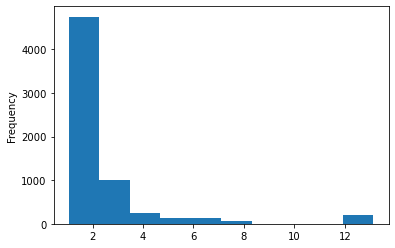

In [44]:
# Check distribution
df_features.Mahalanobis.plot.hist()

#### 5.2.2 Edge features

In this section we will try to detect anomolous edges. We will use non negative matrix factorization. Non-negative matrix factorization tries to find patterns in the adjacency matrix. Once we substract the adjacency matrix with the found patterns we can detect unwanted and missing edges.The NMF algorithm tries to find patterns based on a set of components. To determine how many components there are in the dataset we will use missing value imputation. 

In [7]:
from sklearn.decomposition import NMF

In [13]:
import matplotlib.pyplot as plt

In [ ]:
# Create adjacency matrix based on connectivity
Adj_matrix_Conn = nx.to_numpy_matrix(G_Conn, dtype=bool)

**Determine optimal value of k**

To get an idea of which value to use for k we will use missing value imputation. Here we randomly set values of the adjacency matrix to nan. We calculate the NMF matrices to get a prediction of the missing values. The prediction error is calculated and summed up for every different value of k. We look at the plot to determine an 'optimal value of k'

In [15]:
import random

In [25]:
# Create empty dataframe
PRESS_2 = pd.DataFrame(columns=[loop for loop in range(0,20)], index=[k for k in range(1,8)])

In [26]:
# Loop
for iteration in range(0,20):
    # Create random variable which will be imputed later
    random_i = [random.randint(0,6532) for k in range(0,500)]
    random_j = [random.randint(0,6532) for k in range(0,500)]
    # Create adjacency matrix based on connectivity
    Adj_matrix_Conn = nx.to_numpy_matrix(G_Conn, dtype=bool)
    for i in range(0, len(random_i)):
        j = i
        # change variables NaN
        Adj_matrix_Conn[random_i[i], random_j[j]] = np.nan
    for k in range(1,8):
        # Set up model
        model = NMF(n_components=k, init='nndsvd', max_iter=400)
        # Calculate base of the latent space
        U = model.fit_transform(Adj_matrix_Conn)
        # Calculate the coefficient matrix
        V = model.components_
        # the facotirzed matrix is a dotproduct of both matrices
        factorized_matrix = np.matmul(U,V)
        # create variable to store squared differences
        Sum_diff = np.array([])
        # Calculate differences
        for d in range(0, len(random_i)):
            i = random_i[d]
            j = random_j[d]
            diff = (Adj_matrix_Conn[i,j] - factorized_matrix[i,j])**2
            Sum_diff = np.append(Sum_diff, diff)
        PRESS_2.iloc[(k-1), iteration] = Sum_diff.sum()

In [28]:
# Check output
PRESS_2.sum(axis=1)

1    9939.712941
2    9929.813543
3    9934.420066
4    9928.704868
5    9922.403257
6    9915.095181
7    9911.018250
dtype: float64

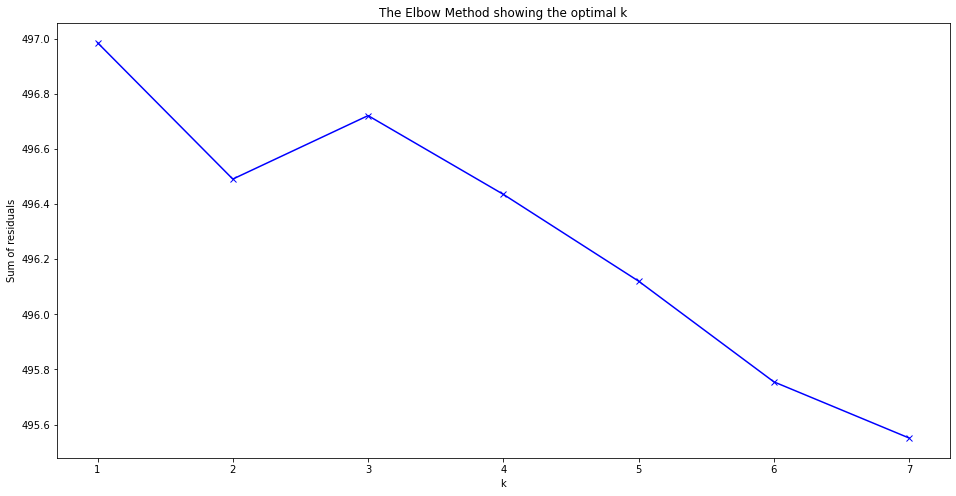

In [27]:
# plot output
K= range(1,8)
plt.figure(figsize=(16,8))
plt.plot(K, np.array(PRESS_2.mean(axis=1)), 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of residuals')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From this plot we see a last steep drop for k=6. We will use k=6 as the rank for our model.

**Set up model**

In [307]:
# Set up model
model = NMF(n_components=6, init='nndsvd')

In [309]:
# Calculate base of the latent space
U = model.fit_transform(Adj_matrix_Conn)

In [310]:
# Check shape
U.shape

(6533, 6)

In [311]:
# Calculate the coefficient matrix
V = model.components_

In [312]:
# Check the shape
V.shape

(6, 6533)

In [313]:
# the facotirzed matrix is a dotproduct of both matrices
factorized_matrix = np.matmul(U,V)

In [314]:
from sklearn import preprocessing

In [327]:
# normalize matrix
factorized_matrix_norm = preprocessing.normalize(factorized_matrix)

In [328]:
# The residual matrix
Residual_matrix = Adj_matrix_Conn - factorized_matrix_norm

In [331]:
# Calculate lower bound
Lower_bound = np.quantile(flatten_Residual, 0.025)

In [340]:
Lower_bound

-0.026825574939998955

In [348]:
# Calculate upperbound
Upper_bound = np.quantile(flatten_Residual, 0.975)

In [349]:
Upper_bound

0.0

In [333]:
# Edges larger than upperbound are classified as unwanted
Unwanted_edges = Residual_matrix>Upper_bound

In [334]:
# The edges lower than the lower bound are missing edges
Missing_edges = Residual_matrix<Lower_bound

In [335]:
# Take the sum of both variables
All_Unwanted_edges = np.array(Unwanted_edges.sum(axis=0)).flatten()
All_Missing_edges = np.array(Missing_edges.sum(axis=0)).flatten()

In [337]:
# Store variables
df_features['Unwanted_edges'] = All_Unwanted_edges
df_features['Missing_edges'] = All_Missing_edges

In [338]:
df_features.head()

,Degree_centrality,Betweenness_centrality,Closeness_centrality,Nr_Nodes,Nr_Edges,Total_Weight,Eigenvalue,ego_Density,Heavy_vicinity,Dominant_edge,Unwanted_edges,Missing_edges
pete.davis@enron.com,0.001378,0.000003,0.313541,8,27,2989.0,2414.157195+0.000000j,1.584963,2.428122,0.973310+0.000000j,8,0
vince.kaminski@enron.com,0.050367,0.025625,0.421937,328,1745,18600.0,2383.983616+0.000000j,1.288537,1.317021,0.791028+0.000000j,328,2940
To_aol.com,0.005052,0.000674,0.387472,34,146,4648.0,2249.756379+0.000000j,1.413244,1.694394,0.914069+0.000000j,33,0
kay.mann@enron.com,0.039651,0.013190,0.388370,258,1757,26265.0,1464.451618+0.000000j,1.345474,1.361999,0.716317+0.000000j,258,1522
suzanne.adams@enron.com,0.003674,0.000026,0.343193,25,208,2567.0,338.469365+0.000000j,1.658199,1.470808,0.741919+0.000000j,24,1007


In [359]:
df_features.describe()

,Degree_centrality,Betweenness_centrality,Closeness_centrality,Nr_Nodes,Nr_Edges,Total_Weight,Eigenvalue,ego_Density,Heavy_vicinity,Dominant_edge,Unwanted_edges,Missing_edges,Mahalanobis
count,6533.000000,6.533000e+03,6533.000000,6533.000000,6533.000000,6533.000000,6533.000000+0.000000j,6533.000000,6533.000000,6533.000000,6533.000000,6533.000000,6533.000000
mean,0.002522,3.405802e-04,0.314374,17.382673,105.517833,1583.314710,176.948333+0.000000j,1.264640,2.849906,0.820255,16.427675,163.312414,2.422634
std,0.006535,2.753625e-03,0.035859,42.489488,387.941833,6687.785492,357.377523+0.000000j,0.339271,6.346724,0.092477,42.586401,549.075543,2.245384
min,0.000153,0.000000e+00,0.157038,2.000000,1.000000,2.000000,2.0000000+0.0000000j,0.000000,1.175586,0.551296,1.000000,0.000000,1.060706
25%,0.000459,2.084655e-07,0.292679,4.000000,4.000000,46.000000,23.1300200+0.0000000j,1.160558,1.566358,0.746860,3.000000,0.000000,1.385783
50%,0.000765,7.790127e-06,0.315084,6.000000,12.000000,125.000000,56.4754540+0.0000000j,1.340978,1.854134,0.811117,5.000000,0.000000,1.646605
75%,0.001990,6.006203e-05,0.337223,14.000000,48.000000,672.000000,176.075708+0.000000j,1.486477,2.453445,0.891847,13.000000,0.000000,2.407421
max,0.146816,1.083224e-01,0.467005,958.000000,8775.000000,163872.000000,5315.700554+0.000000j,1.765557,243.000000,1.000000,958.000000,6011.000000,13.129772


## 5.3 Export feature matrix

In [357]:
df_features.Dominant_edge = df_features.Dominant_edge.astype(float)

In [358]:
df_features.drop(['Nr_Nodes', 'Nr_Edges', 'Total_Weight', 'Eigenvalue'], axis=1).to_csv('files/Feature_matrix_v2.csv')